In [63]:
import importlib
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import pickle
from scipy.spatial import distance_matrix
import hatzakis_lab_tracking as hlt
import tifffile
import trackpy as tp
importlib.reload(hlt)

<module 'hatzakis_lab_tracking' from '/Users/amfaber/Documents/tracking_script/emily_tracking/work_in_progress/hatzakis_lab_tracking.py'>

In [65]:
df = pd.read_csv("full.feather", index_col = 0)

In [66]:
# frame, group = df.groupby("frame").__iter__().__next__()
pos = df[["y", "x"]].to_numpy()
pix = pos.astype(int)
arr = pos % 1
frames = df["frame"].to_numpy()
r = np.sqrt(60)

In [325]:
import tifffile


In [348]:
# %%timeit
idk = tifffile.TiffFile("/Users/amfaber/Documents/tracking_script/emily_tracking/sample_vids/Experiment_Process_001_20220823.tif")
ser = idk.series[0]
padded_vid = np.full((ser.shape[0], ser.shape[2] + 1, ser.shape[2] + 1), np.nan, dtype = np.float64)
load_as_int = np.empty(ser.shape, dtype = np.uint16)
vid = padded_vid[:, :-1, :-1]
idk.asarray(out = load_as_int)
vid[:] = load_as_int
del load_as_int
pass

In [349]:
params = hlt.Params("params.yml")
old = hlt.signal_extractor_no_pos(vid, df, "red", params)

In [353]:
# %%timeit
idk = lambda dim: np.moveaxis(np.arange(-r + 1, r + 1) - arr[:, dim].reshape(-1, 1, 1), -1, dim + 1)
r2 = idk(0)**2 + idk(1)**2
r_ceil = np.ceil(r).astype(int)
idk1, idk2 = [(np.arange(np.ceil(2*r).astype(int)) - r_ceil + 1) + pix[:, i].reshape(-1, 1) for i in range(pix.shape[1])]
idk1 = idk1.reshape(-1, np.ceil(2*r).astype(int), 1)
idk2 = idk2.reshape(-1, 1, np.ceil(2*r).astype(int))
idk1 = idk1.clip(-1, vid.shape[1])
idk2 = idk2.clip(-1, vid.shape[2])
pad_vid = vid.base
# pad_vid = np.pad(vid, [(0, 0), (1, 1), (1, 1)], constant_values = np.nan)
# %timeit np.pad(vid, [(0, 0), (1, 1), (1, 1)], constant_values = np.nan)

# test = pad_vid[frames.reshape(-1, 1, 1), idk1, idk2]
test = pad_vid[frames[:, None, None], idk1, idk2]

# bah = bottleneck.nanmean(np.where(r2 < 9, test, np.nan), axis = 2)
# bah = bottleneck.nanmean(bah, axis = 1)
npway = np.nansum(np.where(r2 <= 9, test, np.nan), axis = (1, 2))
# bah == npway
# np.nanmean(test, axis = (1, 2))

In [ ]:
hlt.make_smallmask_sig_bg()

In [354]:
npway

array([60339., 67325., 62153., ..., 64186., 71541., 67560.])

In [357]:
num = 62153
print((npway == num).sum())
print((old["red_int"] == num).sum())

3
2


12

In [293]:
np.nanmean(np.where(r2 < 9, test, np.nan), axis = (1, 2))

array([2320.73076923, 2321.55172414, 2301.96296296, ..., 2292.35714286,
       2307.77419355, 2252.        ])

In [294]:
bah

array([2320.4       , 2350.26111111, 2282.55555556, ..., 2294.00555556,
       2289.59722222, 2240.54166667])

In [286]:
bottleneck.nanmean(bah, axis = 1)

(36522,)

In [182]:
idk1[0]

array([[-1],
       [-1],
       [ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13]])

In [198]:
mask = np.isnan(test).any(axis = (1,2))

In [201]:
it = iter(test[mask])

In [102]:
pad_vid.shape

(100, 770, 770)

In [99]:
idk1.shape

(36522, 16, 1)

In [94]:
pad_vid.take(frames.reshape(-1, 1, 1), idk1, idk2)

TypeError: only integer scalar arrays can be converted to a scalar index

In [72]:
idk1

array([[[ -2],
        [ -1],
        [  0],
        ...,
        [ 11],
        [ 12],
        [ 13]],

       [[  0],
        [  1],
        [  2],
        ...,
        [ 13],
        [ 14],
        [ 15]],

       [[ -2],
        [ -1],
        [  0],
        ...,
        [ 11],
        [ 12],
        [ 13]],

       ...,

       [[751],
        [752],
        [753],
        ...,
        [764],
        [765],
        [766]],

       [[753],
        [754],
        [755],
        ...,
        [766],
        [767],
        [768]],

       [[752],
        [753],
        [754],
        ...,
        [765],
        [766],
        [767]]])

In [69]:
pix[:, 0]

array([  5,   7,   5, ..., 758, 760, 759])

In [82]:
((idk1[:, 0, 0] > 0) & (idk1[:, -1, 0] < arr.shape[0])) & \
    ((idk2[:, 0, 0] > 0) & (idk2[:, 0, -1] < arr.shape[0]))

array([False, False, False, ...,  True,  True,  True])

In [61]:
idk1.shape

(36522, 16, 1)

In [58]:
((idk1 > 0) & (idk1 <= arr.shape[0]))

array([ True,  True,  True, ...,  True,  True,  True])

In [29]:
np.isnan(pad_vid[0]).all()

True

In [24]:
pad_vid[frames[0].reshape(-1,1,1), idk1[0].reshape(1, -1, 1), idk2[0].reshape(1, 1, -1)]

array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [n

In [21]:
idk1[0]

array([[ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21]])

In [11]:
r_ceil = np.ceil(r).astype(int)

In [360]:
np.array([[1, 0], [0, np.nan]])

array([[ 1.,  0.],
       [ 0., nan]])

In [361]:
a = np.arange(10)
a[np.array([[1, 0], [0, np.nan]])]

IndexError: arrays used as indices must be of integer (or boolean) type

In [350]:
np.where(r2<9, test, np.nan).shape

(280, 6, 6)

In [354]:
np.nanmean(np.where(r2<9, test, np.nan), axis = (1, 2))

array([5.413793103448276, 7.5, 5.321428571428571, 6.518518518518518,
       7.413793103448276, 10.89655172413793, 10.275862068965518,
       10.607142857142858, 12.678571428571429, 14.11111111111111,
       17.11111111111111, 15.5, 22.5, 31.214285714285715, 30.5, 33.5,
       38.111111111111114, 40.41379310344828, 41.5, 52.111111111111114,
       52.5, 52.5, 54.888888888888886, 55.785714285714285, 68.5, 73.5,
       74.11111111111111, 90.82142857142857, 91.78571428571429,
       97.88888888888889, 95.5, 103.41379310344827, 104.5,
       117.54838709677419, 124.21428571428571, 134.58620689655172,
       135.21428571428572, 136.39285714285714, 139.21428571428572,
       140.27586206896552, 143.5, 145.27586206896552, 141.5, 142.5,
       148.88888888888889, 147.88888888888889, 150.82142857142858,
       154.21428571428572, 151.60714285714286, 153.5, 154.5,
       161.36666666666667, 162.5, 166.5185185185185, 169.88888888888889,
       175.5, 184.41379310344828, 184.17857142857142, 190.785

In [337]:
test[r<9] == test

array([[[[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        ...,

        [[ True,  True,  T

In [126]:
idk1

array([[  1,   2,   3, ...,   8,   9,  10],
       [  3,   4,   5, ...,  10,  11,  12],
       [  1,   2,   3, ...,   8,   9,  10],
       ...,
       [739, 740, 741, ..., 746, 747, 748],
       [751, 752, 753, ..., 758, 759, 760],
       [755, 756, 757, ..., 762, 763, 764]])

In [83]:
a = np.arange(10)+5

In [ ]:
hlt.signal_extractor_no_pos()

In [3]:
params = hlt.Params(
    sep = 7,   # afstand mellem centrum af to partikler, 7 er meget lidt så skal være højere ved lavere densitet
    mean_multiplier = 12,  #hvor mange partikler finder den, around 1-3, lavere giver flere partikler
    object_size = 11, #diameter used in tp.locate, odd integer
)
hlt.calibration(params, video_location = "/Users/amfaber/Documents/tracking_script/emily_tracking/sample_vids/s_20.tif")

Using matplotlib backend: MacOSX


/opt/anaconda3/envs/tracking-script/lib/python3.8/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


Found: 0 particles
Current Threshold: 12
Current Separation: 7


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [12]:
# with open("chunking_test.pickle", "rb") as old, open("chunking_test_new.pickle", "rb") as new:
#     old, new = pickle.load(old), pickle.load(new)
old = pd.read_csv(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\chunking_old\0_\_signal_df.csv")
old_2 = pd.read_csv(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\chunking_old_2\0_\_signal_df.csv")
new = pd.read_csv(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\chunking_new\0_\_signal_df.csv")

old = old.reset_index(drop = True)#.drop(columns = ["particle"])
old_2 = old_2.reset_index(drop = True)#.drop(columns = ["particle"])
new = new.reset_index(drop = True)#.drop(columns = "particle")
(old_2.drop(columns = "particle") - new.drop(columns = "particle"))

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,cluster,...,red_int,red_bg,red_sig_pixel_size,red_int_mean,red_bg_mean,red_int_corrected,red_int_gausscorrected,video_counter,set_zero,lowest_state
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-1.136868e-13,-7.105427e-15,0.0,-1.065814e-14,7.105427e-15,0.000000e+00,0.0,0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-1.136868e-13,-1.065814e-14,0.0,0.000000e+00,1.065814e-14,2.273737e-13,0.0,0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-1.136868e-13,3.552714e-15,0.0,-3.552714e-15,3.552714e-15,-2.273737e-13,0.0,0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-1.136868e-13,0.000000e+00,0.0,0.000000e+00,-3.552714e-15,-1.136868e-13,0.0,0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-9.094947e-13,-1.421085e-14,0.0,-2.131628e-14,-1.065814e-14,-3.410605e-13,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,-1.136868e-13,0.000000e+00,0.0,-1.065814e-14,-1.065814e-14,-8.526513e-14,0.0,0,0.0,0
33996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,1.136868e-13,0.000000e+00,0.0,3.552714e-15,-3.552714e-15,1.136868e-13,0.0,0,0.0,0
33997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.000000e+00,7.105427e-15,0.0,7.105427e-15,3.552714e-15,0.000000e+00,0.0,0,0.0,0
33998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,1.136868e-13,0.000000e+00,0.0,3.552714e-15,-1.065814e-14,1.136868e-13,0.0,0,0.0,0


In [23]:
vid = hlt.image_loader_video(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\s_20.tif")

In [24]:
tifffile.imsave("s_20_first_30_frames.tif", vid[:30])

In [24]:
BG_size = 60
lip_int_size = 9
sqrt_BG_size = int(np.ceil(np.sqrt(lip_int_size)))
i_pos = 200.123
j_pos = 300.756
all_is, all_js = np.ogrid[-sqrt_BG_size-(i_pos%1)+1:+sqrt_BG_size-(i_pos%1)+1,
                    -sqrt_BG_size-(j_pos%1)+1:+sqrt_BG_size-(j_pos%1)+1]
all_r2s = all_is**2 + all_js**2
sig = all_r2s <= lip_int_size
i_slice, j_slice, smallmask = hlt.getinds(sig, i_pos, j_pos, vid.shape, sqrt_BG_size)

In [27]:
smallmask

array([[False,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [False, False,  True,  True, False, False]])

In [32]:
smallmask.sum()

29

In [45]:
old["particle"]

0         0_f585119c17d94c85a01c9b804f0ce294
1        16_f585119c17d94c85a01c9b804f0ce294
2        15_f585119c17d94c85a01c9b804f0ce294
3        14_f585119c17d94c85a01c9b804f0ce294
4        13_f585119c17d94c85a01c9b804f0ce294
                        ...                 
33995     1_f585119c17d94c85a01c9b804f0ce294
33996     0_f585119c17d94c85a01c9b804f0ce294
33997    15_f585119c17d94c85a01c9b804f0ce294
33998     7_f585119c17d94c85a01c9b804f0ce294
33999    16_f585119c17d94c85a01c9b804f0ce294
Name: particle, Length: 34000, dtype: object

In [63]:
old

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,cluster,...,red_int,red_bg,red_int_corrected,red_int_gausscorrected,red_int_mean,red_bg_mean,video_counter,set_zero,lowest_state,my_column
0,13.426768,354.737702,13387.672688,1.804771,0.139063,2547.288857,240244.85,0.060203,0,0,...,754.572052,26.354543,-9.709684,-71297.567715,26.019726,32.044426,0,127.784646,0,63658.0
1,422.169923,327.472684,19529.042693,1.764414,0.140493,3903.123058,249011.85,0.050188,0,16,...,878.439241,22.529518,225.083219,-65573.968188,31.372830,27.843004,0,325.513664,0,NaN
2,353.680640,201.417482,14055.771517,1.792224,0.119780,2914.941805,248186.50,0.050987,0,15,...,832.895901,21.248585,216.686943,-68759.824881,28.720548,25.983452,0,285.824726,0,NaN
3,334.005809,235.682724,79786.417845,1.815748,0.127981,13257.345995,400584.90,0.012948,0,14,...,664.042886,21.454503,41.862292,-78923.095481,25.540111,25.972635,0,182.339281,0,NaN
4,321.824267,401.828673,12565.397206,1.836352,0.146128,1808.215844,236115.80,0.066448,0,13,...,699.861965,20.964312,91.896903,-77066.329705,24.995070,26.156633,0,146.970687,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,37.465328,103.909040,22972.321273,1.836432,0.035717,3949.642210,265762.45,0.038084,1999,1,...,776.234379,23.080180,106.909159,-73643.177847,27.722656,28.342859,0,283.230817,0,NaN
33996,13.426768,354.737702,13387.672688,1.804771,0.139063,2547.288857,240244.85,0.060203,1999,0,...,992.526849,25.161414,262.845844,-71059.612918,34.225064,30.849932,0,365.739442,0,62148.0
33997,353.680640,201.417482,14055.771517,1.792224,0.119780,2914.941805,248186.50,0.050987,1999,15,...,654.600607,21.242898,38.556560,-68938.120175,22.572435,27.400105,0,107.529432,0,NaN
33998,177.309901,257.542748,64908.370846,1.904801,0.140919,10494.524141,373667.05,0.014914,1999,7,...,579.914192,21.791931,-52.051818,-71934.745720,19.997041,25.760036,0,35.317513,0,NaN


In [55]:
old[old["particle"] == "0_f585119c17d94c85a01c9b804f0ce294"].sort_values("frame").__len__()

2000

In [60]:
ints = vid[:, i_slice, j_slice][:, smallmask].sum(axis = 1)
old.loc[old["particle"] == "0_f585119c17d94c85a01c9b804f0ce294", "my_column"] = ints

In [62]:
old.my_column

0        63658.0
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
33995        NaN
33996    62148.0
33997        NaN
33998        NaN
33999        NaN
Name: my_column, Length: 34000, dtype: float64

In [3]:
vid_file = tifffile.TiffFile(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\s_20.tif").series[0]

In [33]:
import os, psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss / (1<<30))

2.658466339111328


In [80]:
test = VideoChunker(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\s_20.tif")
next(test)

array([[[2033., 2060., 2060., ..., 2254., 2325., 2038.],
        [2060., 2132., 2094., ..., 2032., 2054., 2057.],
        [2103., 2142., 2198., ..., 2078., 2112., 2208.],
        ...,
        [2086., 2057., 2075., ..., 2021., 2058., 2095.],
        [2113., 2040., 2082., ..., 2022., 2024., 2155.],
        [2089., 2091., 2122., ..., 2054., 2080., 2052.]],

       [[2135., 2090., 2069., ..., 1990., 2043., 2059.],
        [2012., 2124., 2328., ..., 2051., 2139., 2245.],
        [2158., 2204., 2137., ..., 2069., 2091., 2055.],
        ...,
        [2102., 2240., 2146., ..., 2076., 2051., 2028.],
        [2101., 2194., 2136., ..., 2139., 2131., 2102.],
        [2094., 2254., 2123., ..., 2155., 2039., 2088.]],

       [[2045., 2133., 2358., ..., 2025., 2020., 2053.],
        [2050., 2083., 2104., ..., 2053., 2099., 2518.],
        [2070., 2129., 2211., ..., 2080., 2041., 2107.],
        ...,
        [2102., 2139., 2231., ..., 2295., 2057., 2044.],
        [2075., 2085., 2046., ..., 2069., 208

In [92]:
params = hlt.Params(
        lip_int_size = 9,  #originally 15 for first attemps
        lip_BG_size = 80,   # originally 40 for first attemps
        gap_size = 2, # adding gap
        sep = 5,   # afstand mellem centrum af to partikler, 7 er meget lidt så skal være højere ved lavere densitet
        mean_multiplier = 10,  #hvor mange partikler finder den, around 1-3, lavere giver flere partikler
        object_size = 9, #diameter used in tp.locate, odd integer
        n_processes = 8,
        fit_processes = 4,
        pixel_size = 1,
    )

In [97]:
data_type = np.float32
import pickle
with open(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\output_f32\random_pix_fits.pkl", "rb") as file:
    Gs_mean, offs_mean, hsh = pickle.load(file)
vid = vid.astype("float32")
np.subtract(vid, offs_mean.astype(data_type), out = vid)
np.divide(vid, Gs_mean.astype(data_type), out = vid)
photon_movie = vid
# photon_movie = (video - offs_mean.astype(data_type)) / Gs_mean.astype(data_type)
corrected_mov = hlt.Correct_illumination_profile(photon_movie, 0, "")

In [102]:
mean = vid[0].mean()
track_df = tp.batch(vid[:100], params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)
track_df2 = tp.batch(vid[100:200], params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)
track_df3 = tp.batch(vid[:200], params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)

Frame 199: 16 features


In [108]:
%%timeit
track_df = tp.batch(vid[:100], params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)

Frame 99: 16 features
7.78 s ± 295 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
track_df = tp.batch(vid[:300], params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)

Frame 299: 19 features


In [107]:
track_df2["frame"] = track_df2["frame"] + 100
(pd.concat([track_df, track_df2]).reset_index(drop = True) == track_df3).all()

y           True
x           True
mass        True
size        True
ecc         True
signal      True
raw_mass    True
ep          True
frame       True
dtype: bool

In [115]:
track_df.memory_usage().sum() / (1<<20)

0.33431243896484375

In [116]:
mean = vid[0].mean()
old_track_df = tp.batch(old_style_vid, params.object_size, invert = False, minmass = mean*params.mean_multiplier,
                    separation = params.sep, processes = params.n_processes)

Frame 1999: 3263 features


In [88]:
track_df


,y,x,mass,size,ecc,signal,raw_mass,frame,frame


In [43]:
(1 << 30)

1073741824

In [ ]:
series.asarray[]

In [25]:
tifffile.imread(r"C:\Users\andre\Documents\tracking_optimizations\emily_tracking\sample_vids\s_20.tif", key = range())

array([[[2033, 2060, 2060, ..., 2254, 2325, 2038],
        [2060, 2132, 2094, ..., 2032, 2054, 2057],
        [2103, 2142, 2198, ..., 2078, 2112, 2208],
        ...,
        [2086, 2057, 2075, ..., 2021, 2058, 2095],
        [2113, 2040, 2082, ..., 2022, 2024, 2155],
        [2089, 2091, 2122, ..., 2054, 2080, 2052]],

       [[2135, 2090, 2069, ..., 1990, 2043, 2059],
        [2012, 2124, 2328, ..., 2051, 2139, 2245],
        [2158, 2204, 2137, ..., 2069, 2091, 2055],
        ...,
        [2102, 2240, 2146, ..., 2076, 2051, 2028],
        [2101, 2194, 2136, ..., 2139, 2131, 2102],
        [2094, 2254, 2123, ..., 2155, 2039, 2088]],

       [[2045, 2133, 2358, ..., 2025, 2020, 2053],
        [2050, 2083, 2104, ..., 2053, 2099, 2518],
        [2070, 2129, 2211, ..., 2080, 2041, 2107],
        ...,
        [2102, 2139, 2231, ..., 2295, 2057, 2044],
        [2075, 2085, 2046, ..., 2069, 2082, 2046],
        [2059, 2047, 2148, ..., 2080, 2070, 2076]],

       ...,

       [[2099, 2057, 205

,background,cluster,cluster_size,cost,ecc,ep,frame,lowest_state,mass,particle,...,red_int,red_int_corrected,red_int_gausscorrected,red_int_mean,set_zero,signal,size,video_counter,x,y
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.059540,0.012222,-0.000885,0.059540,NaN,0.0,0.0,NaN,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.060936,0.007243,-0.000748,0.060936,NaN,0.0,0.0,NaN,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.077081,0.157581,-0.000737,0.077081,NaN,0.0,0.0,NaN,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.069328,0.004719,-0.001424,0.069328,NaN,0.0,0.0,NaN,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.077031,0.035433,-0.000885,0.077031,NaN,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.061201,0.016544,-0.001050,0.061201,NaN,0.0,0.0,NaN,0.0,0.0
33996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.074980,-0.022314,-0.000285,0.074980,NaN,0.0,0.0,NaN,0.0,0.0
33997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.070135,-0.000802,-0.000796,0.070135,NaN,0.0,0.0,NaN,0.0,0.0
33998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.081027,0.021662,-0.000838,0.081027,NaN,0.0,0.0,NaN,0.0,0.0


In [9]:
df - df_f32

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [24]:
df_all_savinase = pd.read_csv(r"sample_vids\output_new\full_tracked\df.csv")
savinase_locs = df_all_savinase.groupby("particle")[["x", "y"]].mean().to_numpy()

In [25]:
x_y_std = df_all_savinase.groupby("particle")[["x", "y"]].std()
standard_devs = np.sqrt(x_y_std["x"]**2 + x_y_std["y"]**2)

In [26]:
casein_locs = df[~df["particle"].duplicated()][["x", "y"]].to_numpy()

In [27]:
dists = distance_matrix(savinase_locs, casein_locs)

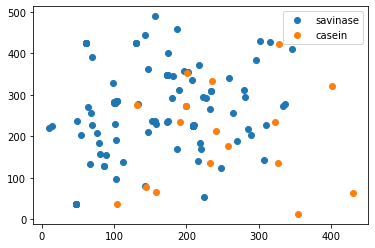

In [37]:
plt.plot(savinase_locs[:, 0], savinase_locs[:, 1], "o", label = "savinase")
plt.plot(casein_locs[:, 0], casein_locs[:, 1], "o", label = "casein")
plt.legend()

In [30]:
closest_caseins = dists.argmin(axis = 1)

In [33]:
(dists[np.arange(len(closest_caseins)), closest_caseins] < 5)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [4]:
print("\_")

\_
